## Part 2

In [208]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import *
import matplotlib.pyplot as plt
import pycountry
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
%matplotlib inline

Getting the texts of the emails

In [8]:
#First let's read the csv and get a DataFrame of the emails
emails_df= pd.read_csv('hillary-clinton-emails/Emails.csv')

In [9]:
emails_df.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We want to create a new dataframe with the concatenation of the email's subjectand the email's body so that we can make the sentiment analisys.

In [10]:
emails_df.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [11]:
#Let's take a look at the 'ExtractedSubject' and 'ExtractedBodyText' columns
emails_df.ExtractedSubject.head()

0                            FW: Wow
1                                NaN
2                  Re: Chris Stevens
3    FVV: Cairo Condemnation - Final
4                                NaN
Name: ExtractedSubject, dtype: object

In [12]:
emails_df.ExtractedBodyText.head()

0                                                  NaN
1    B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...
2                                                  Thx
3                                                  NaN
4    H <hrod17@clintonemail.com>\nFriday, March 11,...
Name: ExtractedBodyText, dtype: object

In [132]:
#We can see that there are NaN in the columns, so first we need to see if for the same row, both of the values
#for both columns are NaN so we can discard that row.
print("Number of NaN in ExtractedBodyText column: %d" % sum(emails_df.ExtractedBodyText.isnull()))
print("Number of NaN in ExtractedSubject column: %d" % sum(emails_df.ExtractedSubject.isnull()))
emails_test=emails_df[~(emails_df.ExtractedBodyText.isnull() & emails_df.ExtractedSubject.isnull())]
#Because we want to concatenate both columns we are going to replace the NaN by a blank space
#We also saw that there are new lines "\n" so we also want to replace them by a blank space so that we can separate
#the words between new lines
emails_test=emails_test.fillna(value=" ").replace(to_replace="\n",value=" ",regex=True)

Number of NaN in ExtractedBodyText column: 1203
Number of NaN in ExtractedSubject column: 1685


In [133]:
#After getting rid of the rows with NaN in both columns mentioned above, we can concatenate them
email_texts=emails_test['ExtractedSubject'].str.cat(emails_test['ExtractedBodyText'], sep=' ')
email_texts=email_texts.to_frame();

In [134]:
#We are going to process the text by deleting punctuation and numbers as well as the stop words defined by nltk
stop_words=stopwords.words('english')+["re", "fw", "fwd",'fvv']
#Punctuation and numbers
email_texts['tokens']=email_texts.ExtractedSubject.apply(WordPunctTokenizer().tokenize)
email_texts['tokens']=[[word.lower() for word in email if word.isalpha()] for email in email_texts['tokens']]
#Stop words
email_texts['tokens']= [[word for word in email if word not in stop_words] for email in email_texts['tokens']]
#Renaming the columns
email_texts.columns = ['email_original_text', 'tokens'] 


In [135]:
#We can see the original text and the process text
email_texts.head()

,email_original_text,tokens
0,FW: Wow,[wow]
1,"B6 Thursday, March 3, 2011 9:45 PM H: Latest...","[thursday, march, pm, h, latest, syria, aiding..."
2,Re: Chris Stevens Thx,"[chris, stevens, thx]"
3,FVV: Cairo Condemnation - Final,"[cairo, condemnation, final]"
4,"H <hrod17@clintonemail.com> Friday, March 11...","[h, clintonemail, com, friday, march, pm, huma..."


In [136]:
#Let's obtain the sentiment analisis of each of the e-mails.
sia = nltk.sentiment.SentimentIntensityAnalyzer()
sentiment=[]
for sentence in email_texts['tokens'].apply(" ".join):
        ss = sia.polarity_scores(sentence)['compound']
        sentiment.append(ss)
email_texts['sentiment']=sentiment

In [258]:
email_texts.head()

,email_original_text,tokens,sentiment,countries
1,"B6 Thursday, March 3, 2011 9:45 PM H: Latest...","[thursday, march, pm, h, latest, syria, aiding...",0.0000,"[(Syria, SY), (Britain, UK), (Iran, IR), (Sout..."
4,"H <hrod17@clintonemail.com> Friday, March 11...","[h, clintonemail, com, friday, march, pm, huma...",0.0000,"[(Syria, SY), (Britain, UK), (Iran, IR), (Sout..."
6,"FW: Anti-Muslim film director in hiding, follo...","[anti, muslim, film, director, hiding, followi...",-0.8225,"[(Syria, SY), (Britain, UK), (Iran, IR), (Sout..."
7,"H <hrod17@clintonemail.corn> Friday, March 1...","[h, clintonemail, corn, friday, march, pm, hum...",0.0000,"[(Syria, SY), (Britain, UK), (Iran, IR), (Sout..."
9,"more on Libya B6 Wednesday, September 12, 2012...","[libya, wednesday, september, pm, libya, libya...",0.0000,"[(Syria, SY), (Britain, UK), (Iran, IR), (Sout..."


In [259]:
#First let's take a look in the structure of the pycountry object.
country_list=list(pycountry.countries)

In [273]:
#We need to add some countries due to in the country_list they appear as the complete official name
all_countries= [('Syria'),('Britain'),('Iran'),('South Korea'),('North Korea'),('Russia'),('Taiwan'),('Palestine')]
for country in country_list:
    all_countries.append((country.name))

In [275]:
#Let's look for the countries in the emails
email_texts['countries'] = [[country for country in all_countries if country.lower() in email] for email in email_texts['tokens']]

In [276]:
#Deleting those rows that do not mention countries
email_texts=email_texts[email_texts.astype(str)['countries'] != '[]']

In [280]:
email_texts.head(6)

,email_original_text,tokens,sentiment,countries
1,"B6 Thursday, March 3, 2011 9:45 PM H: Latest...","[thursday, march, pm, h, latest, syria, aiding...",0.0000,"[Syria, Libya]"
4,"H <hrod17@clintonemail.com> Friday, March 11...","[h, clintonemail, com, friday, march, pm, huma...",0.0000,"[Syria, Libya]"
7,"H <hrod17@clintonemail.corn> Friday, March 1...","[h, clintonemail, corn, friday, march, pm, hum...",0.0000,"[Syria, Libya]"
9,"more on Libya B6 Wednesday, September 12, 2012...","[libya, wednesday, september, pm, libya, libya...",0.0000,[Libya]
11,"B6 Wednesday, September 12, 2012 6:16 PM Fwd...","[wednesday, september, pm, libya, libya, sept,...",0.0000,[Libya]
13,"Anne-Marie Slaughter Sunday, March 13, 2011 ...","[anne, marie, slaughter, sunday, march, pm, ja...",0.9967,"[Russia, Afghanistan, China, France, Iraq, Libya]"


In [462]:
#Reset the index
email_texts=email_texts.reset_index(drop=True)

In [463]:
email_texts.head()

,email_original_text,tokens,sentiment,countries
0,"B6 Thursday, March 3, 2011 9:45 PM H: Latest...","[thursday, march, pm, h, latest, syria, aiding...",0.0,"[Syria, Libya]"
1,"H <hrod17@clintonemail.com> Friday, March 11...","[h, clintonemail, com, friday, march, pm, huma...",0.0,"[Syria, Libya]"
2,"H <hrod17@clintonemail.corn> Friday, March 1...","[h, clintonemail, corn, friday, march, pm, hum...",0.0,"[Syria, Libya]"
3,"more on Libya B6 Wednesday, September 12, 2012...","[libya, wednesday, september, pm, libya, libya...",0.0,[Libya]
4,"B6 Wednesday, September 12, 2012 6:16 PM Fwd...","[wednesday, september, pm, libya, libya, sept,...",0.0,[Libya]


In [464]:
#We create a dictionary in which we are going to get the values for both the sentiment values and the number of occurrences
count_countries=dict()
for country in email_texts['countries']:
    for i in range(len(country)):
        if country[i] in count_countries:
            tmp_count=count_countries[country[i]][0]+1
            tmp_sent=count_countries[country[i]][1]+email_texts['sentiment'][i]
            count_countries[country[i]]=(tmp_count,tmp_sent)
        else:
            count_countries[country[i]]=(1,email_texts['sentiment'][i])

In [465]:
#From the dictionary we created, we can create a new dataframe, for the case of the sentiment column, we need to get the
#average, because we were summing up all the sentiment values.
df_countries=pd.DataFrame.from_dict(count_countries,orient='index')
df_countries.columns=['occurrence','sentiment']
df_countries['sentiment']=df_countries['sentiment']/df_countries['occurrence']
#For the graph, we will take the first 30 countries with more occurrences
df_countries_30=df_countries.sort('occurrence',ascending=False).head(30)

/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [466]:
#Most negatives
df_countries.sort('sentiment',ascending=True).head(5)

/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,occurrence,sentiment
Lesotho,1,-0.91180
Sweden,1,-0.47670
Malaysia,4,-0.47380
Liberia,2,-0.23835
Jamaica,2,-0.23835


In [467]:
#Most positives
df_countries.sort('sentiment',ascending=False).head(5)

/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,occurrence,sentiment
Gabon,1,0.9967
Serbia,1,0.9967
Chad,1,0.9967
Mongolia,1,0.8038
Hungary,1,0.8038


/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/lemr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


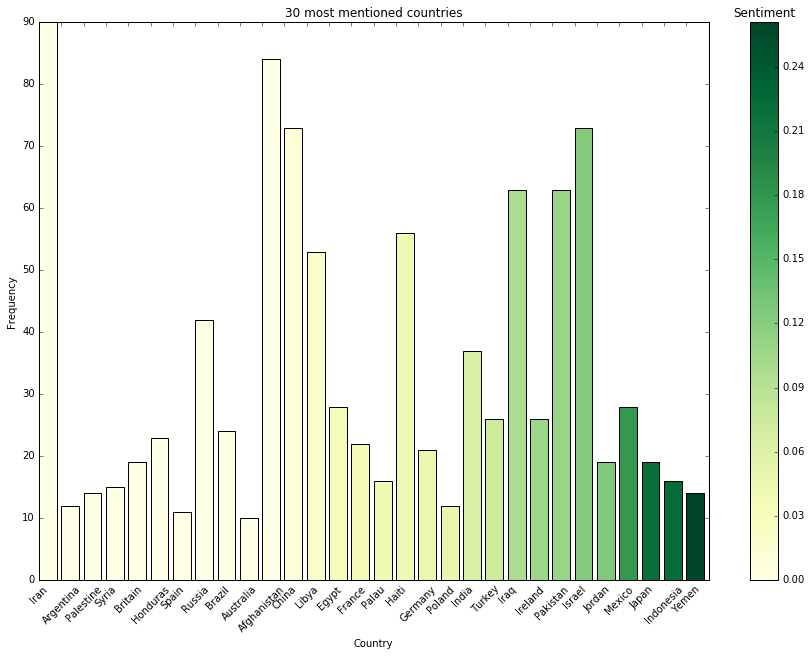

In [470]:
#Plotting everything
y = np.array(df_countries_30.sort('sentiment')['sentiment'])
y_2 = np.array(df_countries_30.sort('sentiment')['occurrence'])
colors = cm.YlGn(y / float(max(y)))
plot = plt.scatter(y,y, c = y, cmap = 'YlGn')
plt.clf()
plt.figure(figsize=(15, 10), dpi=80)
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")
plt.bar(range(len(y)), y_2, color = colors,tick_label=df_countries_30.sort('sentiment').index)
plt.xticks(rotation=45,)
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.title("30 most mentioned countries")
plt.show()

At the end we can see that the country with more mentions is Iran, followed by Afganistan, but it is interesting that we are getting that the emails for those countries were neutral. It is important to mention, that we only looked for the names of the countries and that we only get few countries that were presented in negative mails